In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import coherence_at_resp_concat_job, oas_concat_job, bmrq_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, keep_clean, get_df_mask_chan_signif
import mne
import os
from configuration import base_folder
from params import *

In [3]:
coherence = coherence_at_resp_concat_job.get(global_key).to_dataframe()

In [4]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [5]:
coherence = coherence.set_index(indexes + ['Gender']).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])
coherence = keep_clean(coherence, metrics)

In [6]:
coherence

,index,participant,session,chan,Gender,fmax_resp,max_resp,max_coherence,stai_state,stai_trait,keep_session,Maia_Mean,OAS,BMRQ,log_max_coherence
0,0,P01,baseline,Fp1,F,0.356259,866.407169,0.024449,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.711157
1,1,P01,baseline,Fz,F,0.356259,866.407169,0.072840,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.619490
2,2,P01,baseline,F3,F,0.356259,866.407169,0.095314,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.350575
3,3,P01,baseline,F7,F,0.356259,866.407169,0.026821,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.618577
4,4,P01,baseline,FT9,F,0.356259,866.407169,0.058682,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.835616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2785,P31,odor,FC6,M,0.187505,3108.048063,0.241742,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.419886
2786,2786,P31,odor,FC2,M,0.187505,3108.048063,0.151601,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.886501
2787,2787,P31,odor,F4,M,0.187505,3108.048063,0.506776,29.0,40.0,1.0,2.790774,2.933333,2.681818,-0.679687
2788,2788,P31,odor,F8,M,0.187505,3108.048063,0.272262,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.300991


In [116]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [117]:
coherence_baselined

,participant,session,chan,fmax_resp,max_resp,max_coherence,log_max_coherence
0,P01,odor,Fp1,0.000000,-449.015372,-0.011617,-0.644609
1,P01,odor,Fz,0.000000,-449.015372,-0.009603,-0.141379
2,P01,odor,F3,0.000000,-449.015372,-0.033749,-0.437088
3,P01,odor,F7,0.000000,-449.015372,-0.023511,-2.092176
4,P01,odor,FT9,0.000000,-449.015372,-0.049088,-1.810957
...,...,...,...,...,...,...,...
1855,P31,music,FC6,-0.075002,3304.836158,0.284569,3.197102
1856,P31,music,FC2,-0.075002,3304.836158,0.191901,2.220561
1857,P31,music,F4,-0.075002,3304.836158,0.367052,1.848088
1858,P31,music,F8,-0.075002,3304.836158,0.359002,4.611530


<AxesSubplot: >

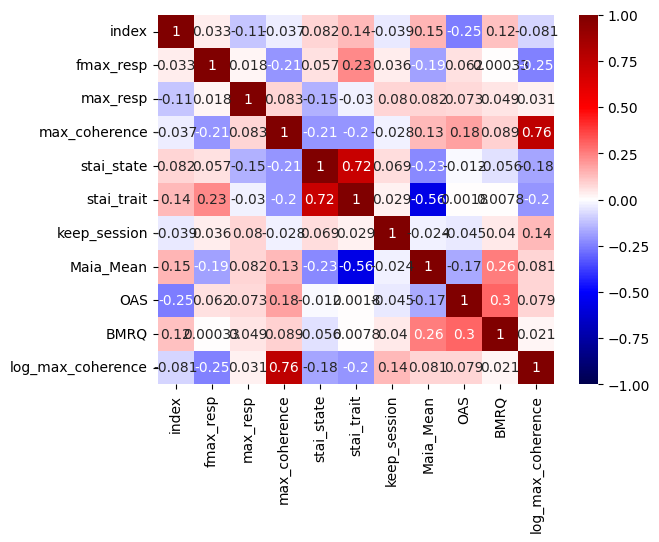

In [118]:
sns.heatmap(coherence.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

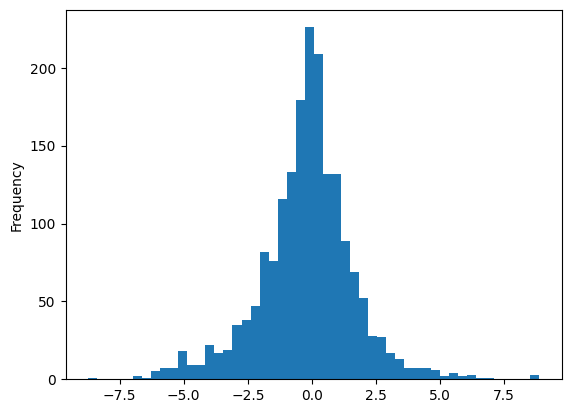

In [119]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

<AxesSubplot: ylabel='Frequency'>

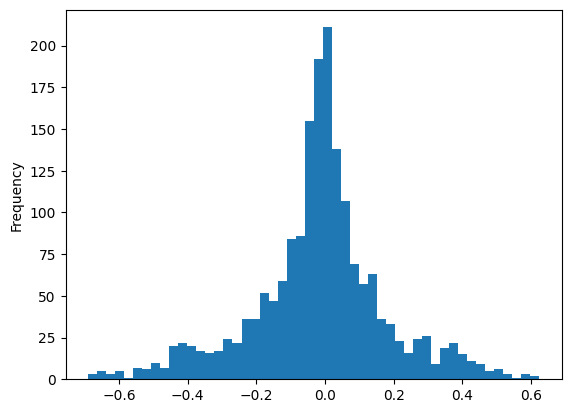

In [120]:
coherence_baselined['max_coherence'].plot.hist(bins = 50)

In [125]:
pos = get_pos()

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


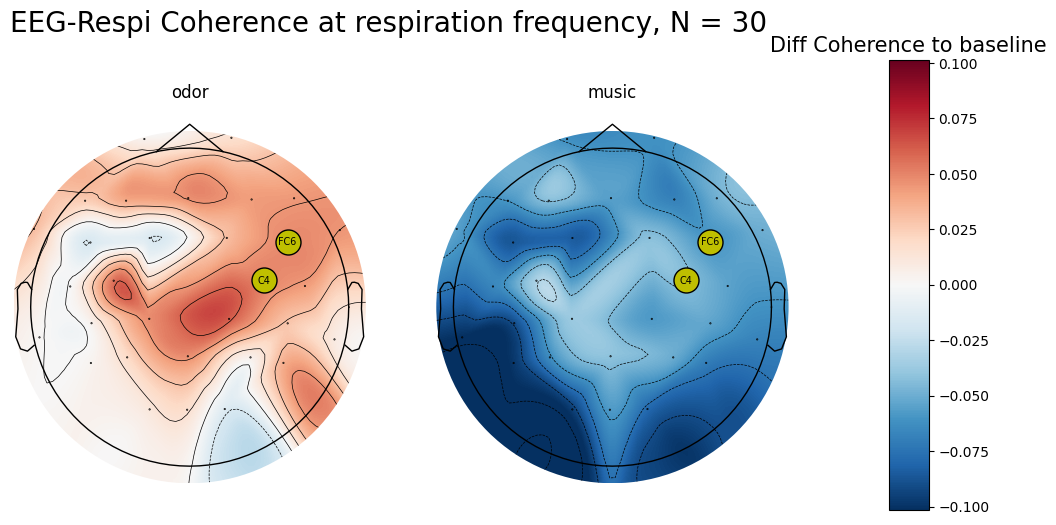

In [127]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'classic')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_classiques.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

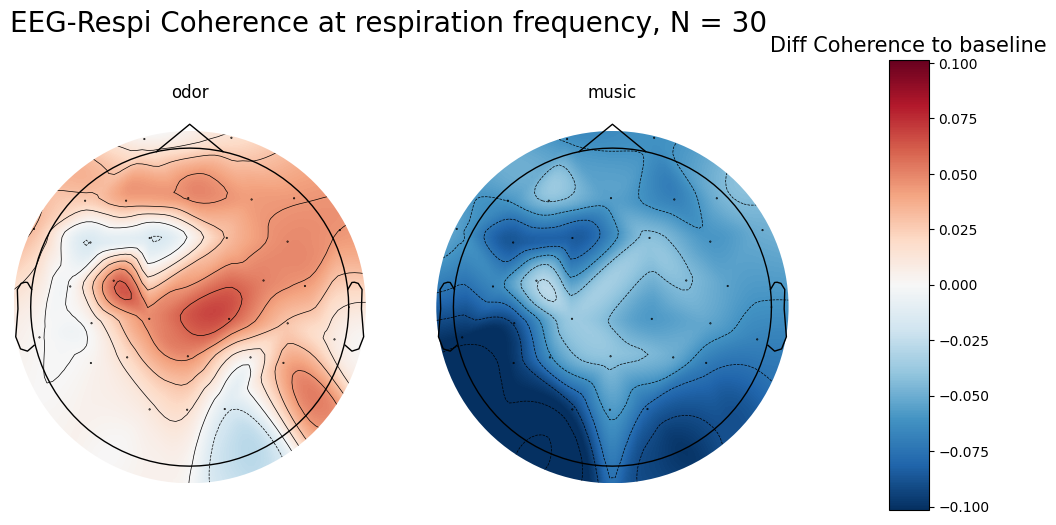

In [128]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'permutations')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_permutations.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

In [14]:
oas = oas_concat_job.get(global_key).to_dataframe().set_index('participant')
bmrq = bmrq_concat_job.get(global_key).to_dataframe().set_index('participant')

In [15]:
q_diff = 0.

metric = 'max_coherence'

for subject in subject_keys:
    
    bmrq_sub = bmrq.loc[subject, 'BMRQ'].round(3)
    oas_sub = oas.loc[subject, 'OAS'].round(3)
    
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject} \n OAS : {oas_sub} - BMRQ : {bmrq_sub}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    plt.close()

# STATS VS BASELINE

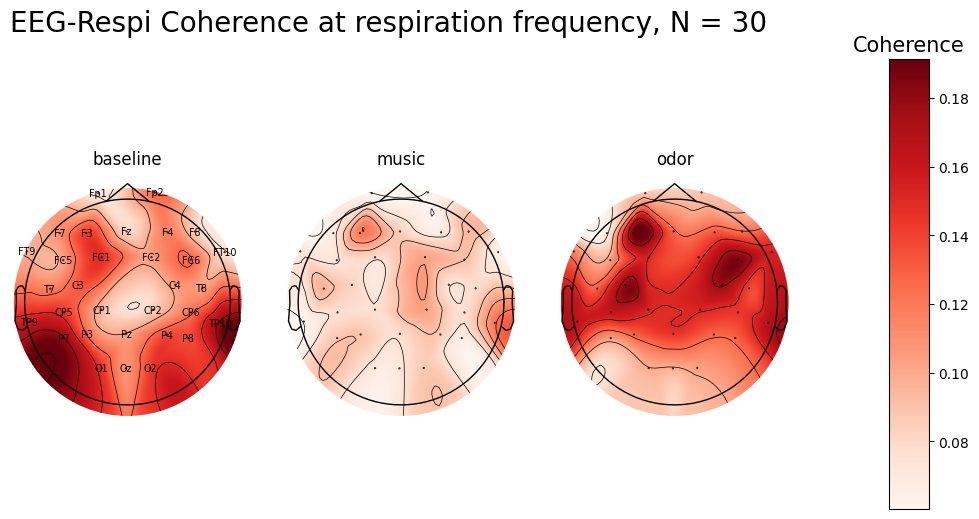

In [130]:
df = coherence.copy()

dfs_masks = []
for cond in ['odor','music']:
    df_to_mask = df[df['session'].isin(['baseline',cond])]
    df_mask = get_df_mask_chan_signif(df = df_to_mask, 
                                      chans = eeg_chans, 
                                      predictor = 'session',
                                      outcome = metric, 
                                      subject = 'participant',
                                      multicomp_method = 'bonf',
                                      stats_type = 'permutations',
                                      diff = 'median')
    df_mask['cond'] = cond
    dfs_masks.append(df_mask)
dfs_masks = pd.concat(dfs_masks)

mask_params = dict(markersize=15, markerfacecolor='y')

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

# vmin = vmin if abs(vmin) > abs(vmax) else -vmax
# vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'raw_coherence_stats_permutations.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

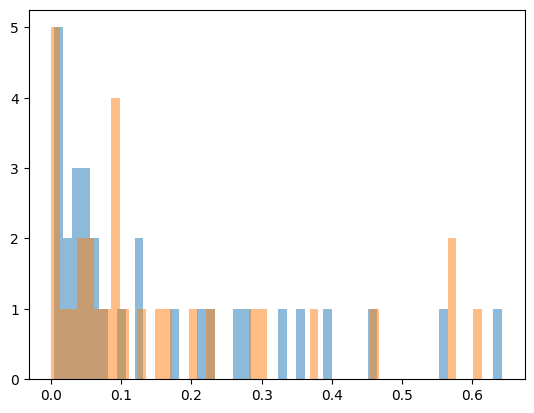

In [97]:
chan = 'Fp1'
x_df = df[(df['session'] == 'baseline') & (df['chan'] == chan)]
y_df = df[(df['session'] == 'odor') & (df['chan'] == chan)]
x = x_df['max_coherence'].values
y = y_df['max_coherence'].values

fig, ax = plt.subplots()
bins = 50
ax.hist(x, bins = bins, alpha = 0.5)
ax.hist(y, bins = bins, alpha = 0.5)
plt.show()

In [110]:
def statistic(x,y):
    return np.median(x) - np.median(y)

In [111]:
res = stats.permutation_test(data=[x,y], statistic=statistic, permutation_type='samples', n_resamples=1000)

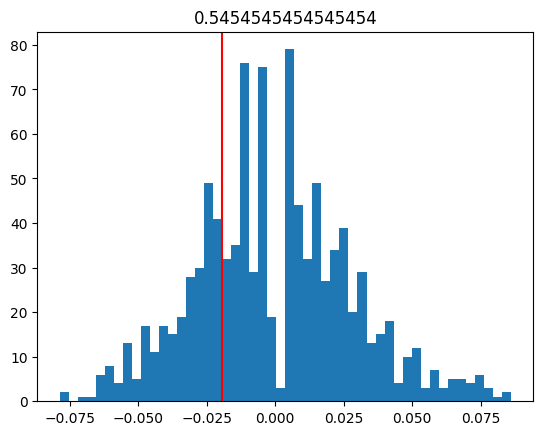

In [112]:
fig, ax = plt.subplots()
ax.hist(res.null_distribution, bins = 50)
ax.axvline(statistic(x,y), color = 'r')
ax.set_title(res.pvalue)
plt.show()